# **Machine Learning in Crowd Simulation**

## **Project Overview**
- The research of Crowd Simulation
- The methods taken to analysis
- what aspects should we take care of
- Current Problem

## Imports

We start by loading necessary libraries and codes.

In [1]:
%load_ext autoreload
%autoreload 2

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import sys
import os

sys.path.append(os.path.abspath(".."))

from src.preprocessing import preprocess_crowd_data

## 1. Data Loading and Preprocessing

Let's define a simple function that loads crowd data

In [2]:
def load_crowd_data(file_path):
    # Load raw data from space-separated text file with specified column names
    df_raw = pd.read_csv(file_path, sep=r'\s+', header=None, 
                        names=['ID', 'FRAME', 'X', 'Y', 'Z'])
    return df_raw

Then we define the file paths in two dicts, one is Corridor and another Bottleneck.

In [5]:
# ==== file path dictionary ====
# --- Corridor Data ---
# Dictionary mapping descriptive names to file paths for corridor experiments
corridor_files = {
    'corridor_015': '../data/Corridor_Data/ug-180-015.txt',  # 15 degree angle
    'corridor_030': '../data/Corridor_Data/ug-180-030.txt',  # 30 degree angle
    'corridor_060': '../data/Corridor_Data/ug-180-060.txt',  # 60 degree angle
    'corridor_085': '../data/Corridor_Data/ug-180-085.txt',  # 85 degree angle
    'corridor_095': '../data/Corridor_Data/ug-180-095.txt',  # 95 degree angle
    'corridor_110': '../data/Corridor_Data/ug-180-110.txt',  # 110 degree angle
    'corridor_140': '../data/Corridor_Data/ug-180-140.txt',  # 140 degree angle
    'corridor_230': '../data/Corridor_Data/ug-180-230.txt',  # 230 degree angle
}

# --- Bottleneck Data ---
# Dictionary mapping descriptive names to file paths for bottleneck experiments
bottleneck_files = {
    'bottleneck_070': '../data/Bottleneck_Data/uo-180-070.txt',  # 70 cm width
    'bottleneck_095': '../data/Bottleneck_Data/uo-180-095.txt',  # 95 cm width
    'bottleneck_120': '../data/Bottleneck_Data/uo-180-120.txt',  # 120 cm width
    'bottleneck_180': '../data/Bottleneck_Data/uo-180-180.txt',  # 180 cm width
}

Then we do data loading and preprocessing within dicts.

- haven't decided whether we should handle 0 values

In [7]:
# ==== data loading ====
print("==== Begin Data Loading ====")
# load all corridor files and store in dictionary with same keys
print("Loading corridor files...")
df_corridors = {
    name: load_crowd_data(path) 
    for name, path in tqdm(corridor_files.items(), total=len(corridor_files))
}

# load all bottleneck files and store in dictionary with same keys
print("Loading bottleneck files...")
df_bottlenecks = {
    name: load_crowd_data(path) 
    for name, path in tqdm(bottleneck_files.items(), total=len(bottleneck_files))
}


==== Begin Data Loading ====
Loading corridor files...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.07it/s]


Loading bottleneck files...


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.64it/s]


In [37]:
# ==== data preprocessing ====
print("=== Begin Data Preprocessing ===")
# preprocess all corridor files and store in dictionary with same keys
print("Processing corridor files...")
df_corridors_preprocessed = {}
for name, data in tqdm(df_corridors.items(), desc="Preprocessing corridors"):
    df_corridors_preprocessed[name] = preprocess_crowd_data(data)

# preprocess all bottleneck files and store in dictionary with same keys
print("Processing bottleneck files...")
df_bottlenecks_preprocessed = {}
for name, data in tqdm(df_bottlenecks.items(), desc="Preprocessing bottlenecks"):
    df_bottlenecks_preprocessed[name] = preprocess_crowd_data(data)

=== Begin Data Preprocessing ===
Processing corridor files...


Preprocessing corridors:  12%|███████▍                                                   | 1/8 [00:00<00:02,  2.49it/s]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
Preprocessing corridors:  25%|██████████████▊                                            | 2/8 [00:01<00:03,  1.72it/s]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
Preprocessing corridors:  38%|██████████████████████▏                                    | 3/8 [00:02<00:04,  1.09it/s]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' i

Processing bottleneck files...


Preprocessing bottlenecks:   0%|                                                                 | 0/4 [00:00<?, ?it/s]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
Preprocessing bottlenecks:  25%|██████████████▎                                          | 1/4 [00:02<00:06,  2.15s/it]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
Preprocessing bottlenecks:  50%|████████████████████████████▌                            | 2/4 [00:04<00:04,  2.20s/it]D:\little_tools\Git\crowd_simulation\src\preprocessing.py:137: FutureWarning: Series.fillna with 'method' i

In this task we are required to mix the data from 'Ring' and 'Bottleneck'
- We start with one specific situation, then we try for different params

In [53]:
# Select one representative dataset from the Ring and Bottleneck scenarios
df_ring = df_corridors_preprocessed['corridor_085'].copy()
df_ring['scene'] = 'Ring'  # Label the scene type as 'Ring'

df_bottle = df_bottlenecks_preprocessed['bottleneck_120'].copy()
df_bottle['scene'] = 'Bottleneck'  # Label the scene type as 'Bottleneck'

# Combine both datasets into a single DataFrame
df_all = pd.concat([df_ring, df_bottle], ignore_index=True)


# print(df_all[['s_k','v','s_k_smooth','v_smooth']].describe()) # ,'s_k_smooth','v_smooth'
print(df_all.head(20))

    ID  FRAME         X        Y        Z       s_k      dx_1      dy_1  \
0    1     48  0.249418  1.30023  1.64638  1.638301  0.694137  0.103840   
1    1     49  0.248985  1.29785  1.64638  1.231417  0.089788  0.499960   
2    1     50  0.247800  1.29357  1.64638  1.141026 -0.089788 -0.499960   
3    1     51  0.246504  1.29109  1.64638  1.484548  0.463822 -0.479788   
4    1     52  0.244752  1.28815  1.64638  1.194850 -0.530556 -0.063760   
5    1     53  0.242406  1.28674  1.64638  1.207421  0.417690 -0.136350   
6    1     54  0.242048  1.28520  1.64638  1.689273 -0.463822  0.479788   
7    1     55  0.239738  1.28409  1.64638  1.441520 -0.417690  0.136350   
8    1     56  0.238503  1.28179  1.64638  1.242641  0.373661 -0.423560   
9    1     57  0.237501  1.28039  1.64638  1.204773  0.115770 -0.558000   
10   1     58  0.237712  1.28002  1.64638  1.334965 -0.221230  0.796650   
11   1     59  0.237609  1.27734  1.64638  1.798803  0.717746 -0.113060   
12   1     60  0.237698  

But we still need to select ... **(we should further decide whether we need this)**

In [35]:
def prepare_datasets(df_all):
    # Create dictionary of dataset variants
    datasets = {
        # Ring scenario subset (filtered by scene == 'Ring')
        'R': df_all[df_all['scene'] == 'Ring'],
        
        # Bottleneck scenario subset (filtered by scene == 'Bottleneck')
        'B': df_all[df_all['scene'] == 'Bottleneck'],
        
        # Full combined dataset (copy of original to avoid modification)
        'R+B': df_all.copy()
    }
    return datasets

## 2. FD Model / FNN Model

### 2.1 FD Model

FD Model is a traditional way of simulating Crowds. We first define a function what fd model is

The original formula is
$$
v = \mathrm{FD}(\bar{s}_K, v_0, T, \ell) 
   = v_0 \left( 1 - e^{\tfrac{\ell - \bar{s}_K}{v_0 T}} \right)
$$

Instead of using `v0`, `T`, `l` here, we rather replece `v0 * T` with `M` because it helps fit, so what we fit became

$$
v = \mathrm{FD}(\bar{s}_K, v_0, M, \ell) 
   = v_0 \left( 1 - e^{\tfrac{\ell - \bar{s}_K}{M}} \right)
$$

In [41]:
# --- Define FD model function for curve fitting ---

def fd_model(s_k, v0, M, l):
    return v0 * (1 - np.exp((l - s_k) / M))

Then we fit the model and do the visualization

--- Ring Fitted Parameters ---
l   = -0.1690 m
T   = 1.5087 s
v0  = 0.8492 m/s

--- Bottleneck Fitted Parameters ---
l   = 0.2930 m
T   = 0.5550 s
v0  = 0.9224 m/s



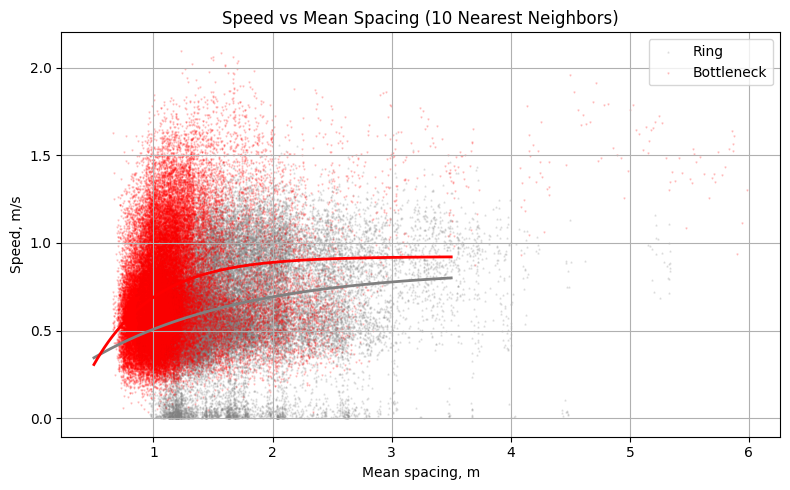

In [43]:
# ==== Fit FD Model and visualization
# --- Plot settings ---
scene_style = {
    'Ring': {'color': 'gray', 'marker': '^'},
    'Bottleneck': {'color': 'red', 'marker': 'v'}
}

plt.figure(figsize=(8, 5))

for scene in ['Ring', 'Bottleneck']: 
    group = df_all[df_all['scene'] == scene]
    x = group['s_k'].to_numpy()
    y = group['v'].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=0.5, alpha=0.2,
                label=scene,
                color=scene_style[scene]['color'],
                marker=scene_style[scene]['marker'])

    # Fit model
    initial_guess = [1.5, 0.8, 0.6]
    popt, _ = curve_fit(fd_model, x, y, p0=initial_guess, maxfev=10000)
    v0, M, l = popt
    T = M / v0

    # Print results
    print(f"--- {scene} Fitted Parameters ---")
    print(f"l   = {l:.4f} m")
    print(f"T   = {T:.4f} s")
    print(f"v0  = {v0:.4f} m/s\n")

    # Plot fitted curve
    x_fit = np.linspace(0.5, 3.5, 300)
    y_fit = fd_model(x_fit, *popt)
    plt.plot(x_fit, y_fit,
             color=scene_style[scene]['color'],
             linewidth=2)

# Final plot formatting
plt.xlabel("Mean spacing, m")
plt.ylabel("Speed, m/s")
plt.title("Speed vs Mean Spacing (10 Nearest Neighbors)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/speed_vs_spacing.png", dpi=300)
plt.show()

### 2.2 MLP Model

We start with define a function that takes the structure of MLP and create models.

In [ ]:
architecture_list = [(1,), (2,), (3,), (4,2), (5,2), (5,3), (6,3), (10,4)]
mlp_models = {arch : build_mlp(arch) for arch in architecture_list}
features = ['s_k'] + [f'dx_{i}' for i in range(1, 11)] + [f'dy_{i}' for i in range(1, 11)] # (should choose v_smooth or v) (s_k_smooth or s_k)